# STAT 441: Statistical Learning - Classification
## Classifying Astrophysical Images
##**ResNet50 Model**
Prepared by:\
Raghuv Bansal

In [7]:
# ! pip install tensorflow

import os
import numpy as np
import tensorflow as tf # Required for image_dataset_from_directory
import pandas as pd
import matplotlib.pyplot as plt

# Re-importing necessary TensorFlow Keras components for this block
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Normalization, RandomRotation, RandomShear, RandomZoom, RandomFlip
from tensorflow.keras.models import load_model

from google.colab import drive

## Importing the dataset

In [8]:
drive.mount('/content/drive')

training_path   = '/content/drive/MyDrive/astro_dataset_maxia_data/training'
test_path       = '/content/drive/MyDrive/astro_dataset_maxia_data/test'
validation_path = '/content/drive/MyDrive/astro_dataset_maxia_data/validation'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Creating training, validation and testing batches for images.

In [9]:
BATCH_SIZE =32
IMAGE_SIZE =(256, 256)

In [10]:
training_batch = tf.keras.utils.image_dataset_from_directory(
    directory=training_path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE)

validation_batch = tf.keras.utils.image_dataset_from_directory(
    directory=validation_path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE)

test_batch = tf.keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE)

Found 2411 files belonging to 12 classes.
Found 655 files belonging to 12 classes.
Found 344 files belonging to 12 classes.


From the TensorFlow documentation the supported image formats: `.jpeg`, `.jpg`, `.png`, `.bmp`, `.gif`. We must verify whether all images are in such format before loading in our batches.

In [11]:
class_names = training_batch.class_names

Visualizing the Images

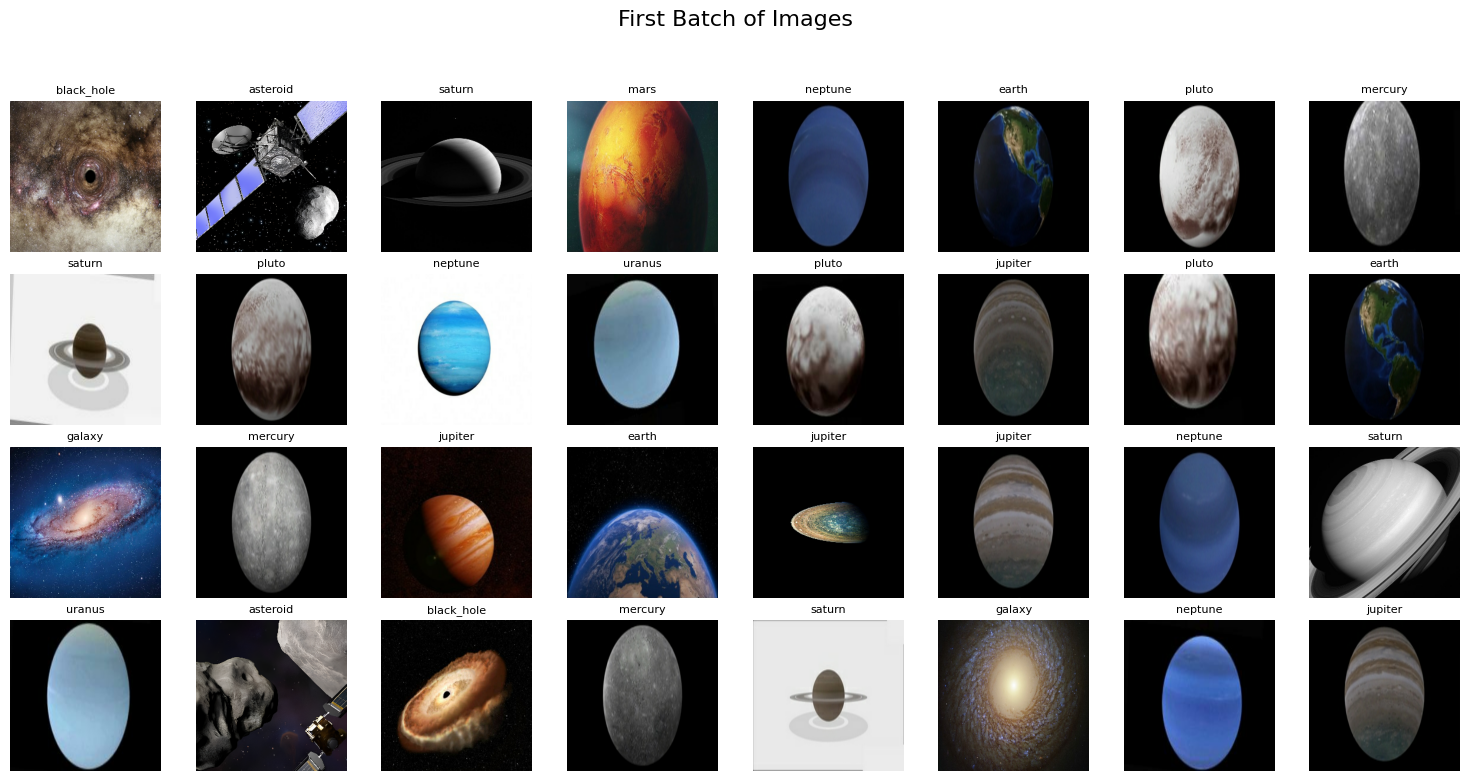

In [12]:
for images, labels in training_batch.take(1):
    num_images = images.shape[0]
    rows = int(num_images / 8) + 1

    plt.figure(figsize=(15, 10))
    plt.suptitle("First Batch of Images", fontsize=16)
    for i in range(num_images):
        plt.subplot(rows, 8, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))

        # Get the class name for the title
        label_index = labels[i].numpy()
        title = training_batch.class_names[label_index]

        plt.title(title, fontsize=8)
        plt.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    break

Implementing image preprocessing by:
1. Resizing the image (completed and resized to (256,256) )
2. Normalizing the pixel values
3. Data Augmentations\
  3.1. Normalization of pixel values\
  3.2. Random Rotations\
  3.3. Random Shear\
  3.4. Random Zoom\
  3.5. Random Flip

In [ ]:
norm_layer = Normalization(axis=-1) #Adapting the normalization layer
images_only = training_batch.map(lambda x, y: x)
norm_layer.adapt(images_only)
preprocess = [
    norm_layer, # we normalize the images per channel (RGB)
    RandomRotation(0.5), # random rotations of images
    RandomShear(x_factor=(0.0, 0.2), y_factor=(0.0, 0.2)), # Random shear of images (factors within [0,1])
    RandomZoom(0.2),
    RandomFlip(mode="horizontal_and_vertical") # Random flip of the images
    ]

## Model Implementaion

In [ ]:
def build_resnet50_model(learning_rate: float, weight_decay: float):
    # Base ResNet50 feature extractor
    mResNet50 = ResNet50(
        include_top=False,
        input_shape=(256, 256, 3),
        pooling='avg',
        weights='imagenet',
        name="resnet50")

    for layer in mResNet50.layers:
        layer.trainable = False

    # mResNet50.summary() (useful in testing and debugging, but no use on printing the summary for the clean script)

    model = Sequential(
        [Input(shape=(256, 256, 3), batch_size=BATCH_SIZE)] + preprocess + [
            mResNet50,
            Dropout(0.5),
            Dense(256, activation='relu', kernel_regularizer=l2(weight_decay)),
            Dense(len(class_names), activation='softmax')])

    opt = Adam(learning_rate=learning_rate)

    model.compile(
        loss=SparseCategoricalCrossentropy(from_logits=False),
        optimizer=opt,
        metrics=["accuracy"])

    return model


### Neural Network Implementaion

We will implement multiple pre-trained Convolutional Neural Networks (CNN) and fine-tune them to our astrophysical dataset. Such models include:
* VGG16
* VGG19
* ResNet50
#### ResNet50

In [ ]:
save_dir = "/content/drive/MyDrive/astro_dataset_maxia_data"
os.makedirs(save_dir, exist_ok=True)

# ----- hyperparameter grid -----
LR_LIST    = [0.01, 0.001, 0.0001]   # learning rates to try
WD_LIST    = [0.0, 0.001, 0.0001]    # L2 weight decay values
MAX_EPOCHS = 12                   # max epochs per combo

results = []
best_config = None

acc_by_combo = {}

for lr in LR_LIST:
    for wd in WD_LIST:
        print(f"\n=== Training ResNet50 with lr={lr}, weight_decay={wd} ===")

        model = build_resnet50_model(learning_rate=lr, weight_decay=wd)

        ckpt_path = f"{save_dir}/resnet50_lr{lr}_wd{wd}.keras"
        checkpoint = ModelCheckpoint(
            ckpt_path,
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=False,
            verbose=1,)

        early_stop = EarlyStopping(
            monitor="val_accuracy",
            mode="max",
            patience=2,
            restore_best_weights=True,
            verbose=1,)

        history = model.fit(
            x=training_batch,
            validation_data=validation_batch,
            epochs=MAX_EPOCHS,
            verbose=2,
            batch_size=BATCH_SIZE,
            callbacks=[checkpoint, early_stop],)

        val_accs = history.history["val_accuracy"]
        num_epochs_run = len(val_accs)

        # build a length-12 list of accuracies for this combo
        full_curve = []
        for ep_idx in range(MAX_EPOCHS):
            if ep_idx < num_epochs_run:
                full_curve.append(val_accs[ep_idx])
            else:
                full_curve.append(val_accs[-1])

        acc_by_combo[(lr, wd)] = full_curve

        best_val = max(val_accs)
        config_info = {
            "learning_rate": lr,
            "weight_decay": wd,
            "best_val_accuracy": best_val,
            "model_path": ckpt_path,}
        results.append(config_info)

        if (best_config is None) or (best_val > best_config["best_val_accuracy"]):
            best_config = config_info

print("\nBest hyper-parameter combo (by best val_accuracy):")
print(best_config)

### Summary Table

In [ ]:
combo_order = [(lr, wd) for lr in LR_LIST for wd in WD_LIST]

row1 = ["", "Learning Rate"] + [lr for lr in LR_LIST for _ in WD_LIST]
row2 = ["", "Weight Decay"] + [wd for _ in LR_LIST for wd in WD_LIST]
row3 = ["", "Epoch"] + [""] * len(combo_order)

table = [row1, row2, row3]

for ep in range(1, MAX_EPOCHS + 1):
    row = ["", ep]
    for (lr, wd) in combo_order:
        acc = acc_by_combo[(lr, wd)][ep - 1]
        row.append(acc)
    table.append(row)

# Convert summary to DataFrame and save as CSV
df_summary = pd.DataFrame(table)
csv_path = f"{save_dir}/resnet50_val_accuracy_full_grid.csv"
df_summary.to_csv(csv_path, index=False, header=False)

print("\nSaved CSV summary to:")
print(csv_path)

##Print Summaries

In [ ]:
# Load the best model
best_model = load_model(best_config["model_path"])

print("\nLoaded best ResNet50 model from hyperparameter search:")
print(f"  learning_rate       = {best_config['learning_rate']}")
print(f"  weight_decay (L2)   = {best_config['weight_decay']}")
print(f"  best val_accuracy   = {best_config['best_val_accuracy']:.4f}")
print(f"  model file          = {best_config['model_path']}\n")

best_model.summary()

model = best_model

results_df = pd.DataFrame(results)

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score)

test_loss, test_acc = model.evaluate(test_batch, verbose=0)
print(f"Test loss (Keras):      {test_loss:.4f}")
print(f"Test accuracy (Keras):  {test_acc:.4f}")

def collect_predictions(model, dataset):
    y_true, y_pred, y_prob = [], [], []
    for images, labels in dataset:
        probs = model.predict(images, verbose=0)
        preds = np.argmax(probs, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_prob.extend(probs)

    return np.array(y_true), np.array(y_pred), np.array(y_prob)

y_true_test, y_pred_test, y_prob_test = collect_predictions(model, test_batch)

acc       = accuracy_score(y_true_test, y_pred_test)
bal_acc   = balanced_accuracy_score(y_true_test, y_pred_test)
f1_macro  = f1_score(y_true_test, y_pred_test, average="macro")
auc_macro = roc_auc_score(
    y_true_test,
    y_prob_test,
    multi_class="ovr",
    average="macro")

print(f"\nSklearn accuracy:          {acc:.4f}")
print(f"Balanced accuracy:         {bal_acc:.4f}")
print(f"Macro F1:                  {f1_macro:.4f}")
print(f"Macro AUC (OvR):           {auc_macro:.4f}")

print("\nClassification report (test set):")
print(classification_report(y_true_test, y_pred_test, target_names=class_names))

print("Confusion matrix (test set):")
print(confusion_matrix(y_true_test, y_pred_test))

print("\nAUC by class (OvR):")
for i, cname in enumerate(class_names):
    auc_i = roc_auc_score((y_true_test == i).astype(int), y_prob_test[:, i])
    print(f"{cname}: {auc_i:.4f}")

